# RDataScience Oreilly

### Note how can Resizing plots in the R kernel for Jupyter notebooks
https://blog.revolutionanalytics.com/2015/09/resizing-plots-in-the-r-kernel-for-jupyter-notebooks.html

    library(repr)

    # Change plot size to 4 x 3
    options(repr.plot.width=4, repr.plot.height=3)
    
### Note2 Generate a table 
https://www.tablesgenerator.com/markdown_tables


### Note 4 - DataFrames

In [1]:

library(tidyverse)
library(ggplot2)
#these packages provides data on flights, world development and basaball
library(nycflights13)
library(gapminder)
library(Lahman)

library(gridExtra) #multiple grid
library(repr) # Change plot size to 4 x 3
library(stringr)
library(forcats) #factors
library(lubridate)

library(modelr)
options(na.actions = na.warn) 


Warning message:
"package 'tidyverse' was built under R version 3.5.3"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.2.1     v purrr   0.3.4
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0
Warning message:
"package 'ggplot2' was built under R version 3.5.3"Warning message:
"package 'tibble' was built under R version 3.5.3"Warning message:
"package 'tidyr' was built under R version 3.5.3"Warning message:
"package 'readr' was built under R version 3.5.3"Warning message:
"package 'purrr' was built under R version 3.5.3"Warning message:
"package 'dplyr' was built under R version 3.5.3"Warning message:
"package 'stringr' was built under R version 3.5.3"Warning message:
"package 'forcats' was built under R version 3.5.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning mess

## Part 4 Model (pag. 341)  368

The goal of a model is to provide a simple low-dimensional summary of a datasets, we only cover "predictive" model (there is other "data discovery", but we're not going to discuss), these two model are sometimes called supervised and unsupervised 

Through all these chapters:

- Chapter 18 - Model Basics with modelr - pag 345
- Chapter 19 - Model Building - pag 375
- Chapter 20 - Many Models with purrr and broom - pag 397

### Chapter 18 - Model Basics with `modelr` - pag 345
we´re going to use model to partition data into patterns and residuals, strong patterns will hide subtler trends , se we will use models to helps peel back layers of structures as we explore dataset.

In this chapter you will understand the essence of model before to apply to real data in the next chapter, there are 2 parts to a model:

1. `family of models` the express a precise, but generic, pattern that you want capture (might be a strainght line or quadratic curve)
2. `fitted model`  by fiding the model from the family that is the closest to your data now you will make it specific.

the goal of a model is not to uncover truth, but to discover a simple approximation that is stil useful


**Prerequsites**

we'll use the `modelr` package, which wraps around base Rms modeling function, additionalty:

    library(tidyverse)
    library(modelr)
    options(na.actions = na.warn)

#### <font color='blue'> 18.1) A Simple Model (pag. 346) </font>    
let's take a look at the dataset `sim1`, here you can see a stron patter in the data (looks linear i.e `y =a_0 + a_1*x`), so let's start by getting a feel for what model from that family look like by randomly genertin a few, to do that we use `geom_abline()`

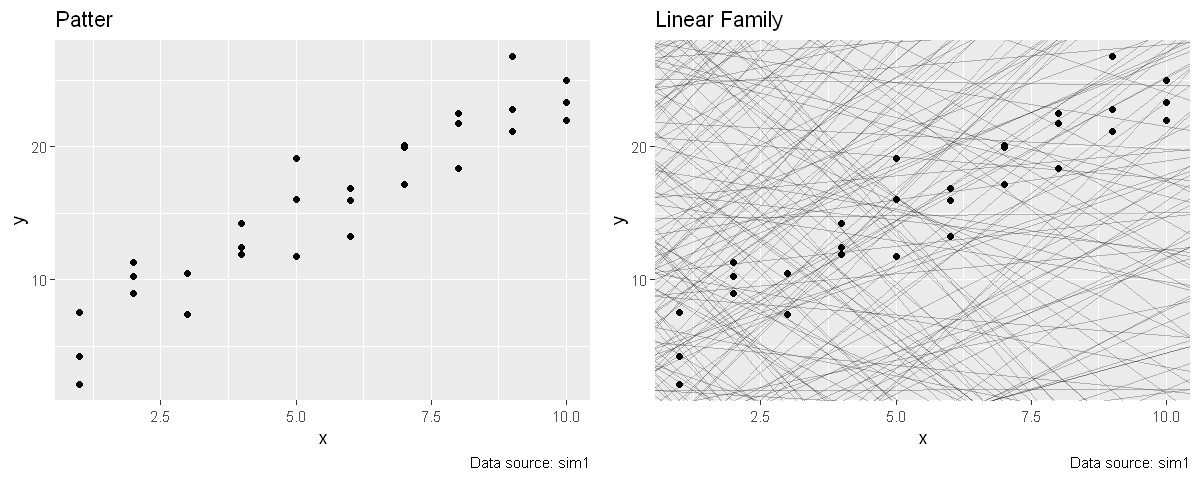

In [3]:
a1<-ggplot(sim1, aes(x,y)) + geom_point() + 
labs(title = "Patter",caption = "Data source: sim1")

models <- tibble(a1 = runif(250,-20,40), a2=runif(250,-5,5))

a2<-ggplot(sim1, aes(x,y)) + geom_abline(aes(intercept = a1, slope = a2), data = models, alpha= 1/4) + geom_point() + 
labs(title = "Linear Family",caption = "Data source: sim1")

options(repr.plot.width=10, repr.plot.height=4)
grid.arrange(a1, a2, nrow = 1)

There are 250 models in the second plot, many of them are really bad! we need to find the best model (the one "closest" to the data) to do that we need to quantify the distance between the `data` and a `model`.

This distance is just the difference between the `y` value given by the model (**the prediction** ) and the actual `y` in the data (**the response**).

since we are working with a linear model(we can use the straight equation `y =a+ bx`), we have simulated 250 values of `a`: intercept with `y` axis and `b`:slope , but we need to turn into a R function.

1. Generate the models (obtain the y values)

        #modeling y values 
        model1<- function(a, data) {
            #intercep with y axis a[1] and slope a[2]
            a[1] + a[2]*data$x
        }

2. compute an overall distance, one way is with the `root-mean-squared deviation`, it compute the difference between the values, square them, average them and take the square root

        measure_distance<-function(mod,data){
            diff<-data$y- model1(mod,data)
            sqrt(mean(diff^2))

        }
        
we can compute an example with a particular value eg. `c(7,1.5)`

In [18]:
#modeling y values 
model1<- function(a, data) {
    #intercep with y axis a[1] and slope a[2]
    a[1] + a[2]*data$x
}

measure_distance<-function(mod,data){
    diff<-data$y- model1(mod,data)
    sqrt(mean(diff^2))
    
}

measure_distance(c(7,1.5),sim1)

[1] 2.665212

but we need to repeat this procces for all combinations, so we use `purrr` library, but after that we will create an auxiliar funciton because our model expects as numerica vector of lenght of 2

In [21]:
# we use this function to create a vector, which after will be used by our function model1
sim1_dist<-function(a1,a2) {
    measure_distance(c(a1,a2),sim1)
}

models<- models %>% mutate(dist = map2_dbl(a1,a2,sim1_dist))

Now, let's take the 10 best model on to the data

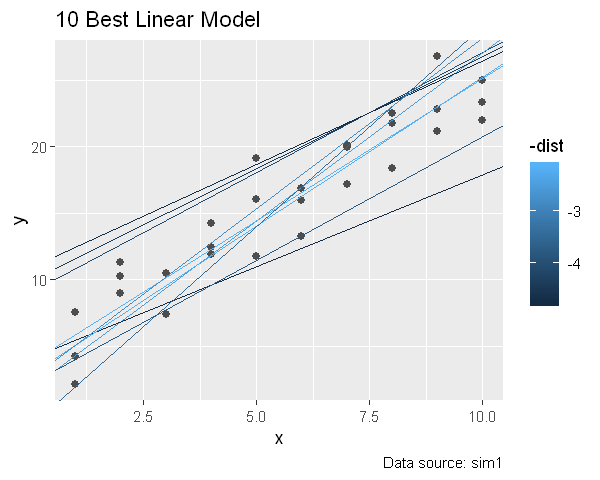

In [33]:
a1<-ggplot(sim1, aes(x,y)) + geom_point(size = 2, color = "grey30") +
geom_abline(aes(intercept = a1, slope = a2,color = -dist),
            data = filter(models, rank(dist)<=10)
            ) + 
labs(title = "10 Best Linear Model",caption = "Data source: sim1")

options(repr.plot.width=5, repr.plot.height=4)
grid.arrange(a1, nrow = 1)

now you could think that is very hard, because we can find other models, but there are better way to find the best model.

- a numerical minimization tool called `Newton-Raphson`
- R has tool desigen for linear model called `lm()`

In [35]:
#first
best<-optim (c(0,0), measure_distance, data = sim1)
best$par

#second
sim1_mod<-lm(y~x, data = sim1)
sim1_mod

[1] 4.222248 2.051204


Call:
lm(formula = y ~ x, data = sim1)

Coefficients:
(Intercept)            x  
      4.221        2.052  


#### <font color='blue'> 18.2) Visualizing Models (pag. 354) </font>    
We´re goint to focus on understanding a model by looking at its predictions, it´s useful to see that the model doesn't capture, the so-called residual that are left subtracting the predictions from the data,

**Predictions**

to visualize the prediction from a model,we start by generating an evenly spaced grid of values that cover the region where out data lies (to do this we use `modelr::data_grid()`), after that we add predictions using `modelr::addpredictions()` and finally we plor the predictions 

In [8]:
# first create the grid
grid<-sim1 %>% data_grid(x)

#add predictions 
# we need our model
sim1_mod<-lm(y~x, data = sim1)
grid <- add_predictions(grid,sim1_mod)
head(grid)

x,pred
1,6.272355
2,8.323888
3,10.375421
4,12.426954
5,14.478487
6,16.530020


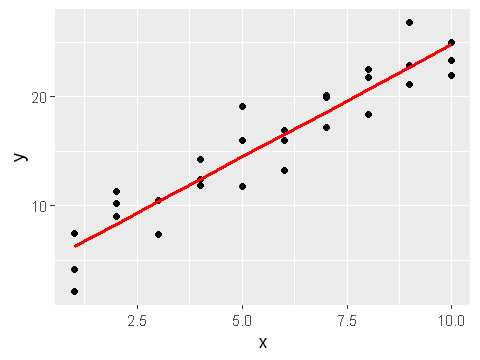

In [15]:
a1<-ggplot(sim1,aes(x))  + geom_point(aes(y=y)) + 
geom_line(aes(y = pred), data = grid, colour = 'red', size = 1)

options(repr.plot.width=4, repr.plot.height=3)
grid.arrange(a1, nrow = 1)

**Residuals**

the flip side of predictions (which tell you the pattern that the model has captured ) are `residuals` , which tell you what the model has missed (`add_residuals()`), one way to understand them is with draw a frequency polygon or you will often re-create plits using residual instead of the original predictor

x,y,resid
1,4.199913,-2.0724420
1,7.510634,1.2382791
1,2.125473,-4.1468822
2,8.988857,0.6649694
2,10.243105,1.9192174
2,11.296823,2.9729351


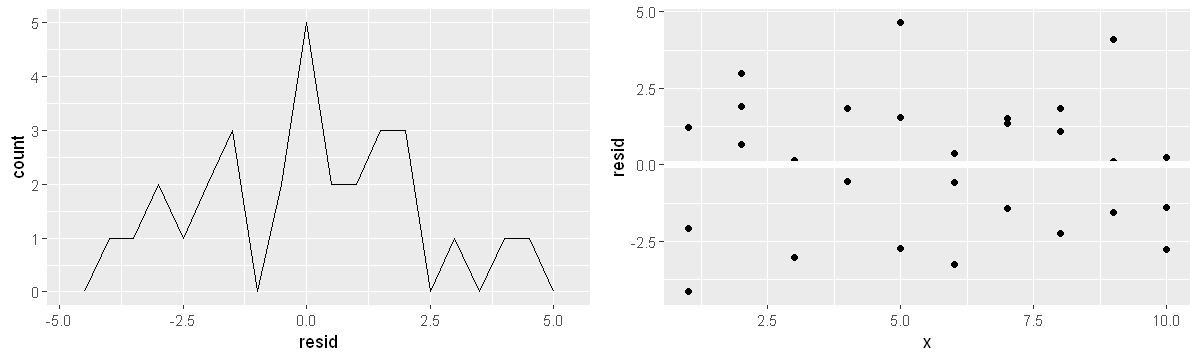

In [27]:
# we need our model
sim1_mod<-lm(y~x, data = sim1)
sim1<- add_residuals(sim1,sim1_mod)
head(sim1)

cat("")

a1<- ggplot(sim1, aes(resid)) + geom_freqpoly(binwidth = .5)


a2<-ggplot(sim1, aes(x, resid)) + geom_point() + geom_ref_line(h = 0)


options(repr.plot.width=10, repr.plot.height=3)
grid.arrange(a1,a2, nrow = 1)


**Formules and Model Families**
the majority of modeling function in R use a standard conversion from formulas to function, e.g `y~x` is traslated to `y = a1+a2x` to know how it actually works you can use `model_matrix` which take a dataframe and a formula an return a `tibble` that defines the model.

Note: the way that R adds the intercept to the model is just by having a column that is full of ones (if you don't want it, only add at the final `-1`)

In [34]:
df<-tribble(~y,~x1,~x2,
          4,2,5,
          5,1,6)
model_matrix(df,y~x1+x2)

#model_matrix(df,y~x1+x2-1)

(Intercept),x1,x2
1,2,5
1,1,6


**Categorical Variables**
when the predictor is continuous is straightforward to create a formula, but when it was is categorical we need to convert in a numerical variable eg. sex can be 1:mean and 0:female, however when we're working with categorical data x will predict the mean value of each category , because the mean minimize the root mean-squared distance eg. 


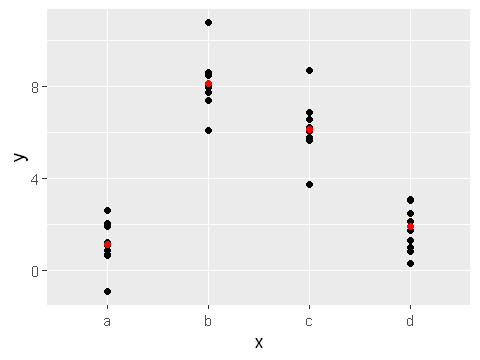

In [21]:
mod2<-lm(y~x, data = sim2)
grid<- sim2 %>% data_grid(x) %>% add_predictions(mod2)
a1<-ggplot(sim2,aes(x)) + geom_point(aes(y=y)) + geom_point(aes(y = pred), data = grid, color = "red")

options(repr.plot.width=4, repr.plot.height=3)
grid.arrange(a1, nrow = 1)


**Interactions (continuos and categorical)**
we will be working with `sim3` which contains two predictor variables (one of the is categorical and other is continuous), we have two possible fit models:

    mod1<-lm(y ~ x1 + x2, data = sim3)
    mod2<-lm(y~ x1*x2, data = sim3)

- `+` the model will estimate each effect indepedent of all the others
- `*` called interation e.g `y~ x1*x2` is traslated to `y = a0 + a1*a1 + a2*a2 + a12*a1*a2`

Note: to generate predictions from **both** models simultaneously, we can use `gather_predictions()` other options `spread_preditctions`, and the same time we can calculate their residuals with `gather_residual()`

In [31]:
mod1<-lm(y ~ x1 + x2, data = sim3)
mod2<-lm(y~ x1*x2, data = sim3)
grid<-sim3 %>% data_grid(x1,x2) %>% gather_predictions (mod1,mod2)

head(grid)

tail(gather_residuals(sim3,mod1,mod2))

model,x1,x2,pred
mod1,1,a,1.674928
mod1,1,b,4.562739
mod1,1,c,6.480664
mod1,1,d,4.034515
mod1,2,a,1.478190
mod1,2,b,4.366001


model,x1,x2,rep,y,sd,resid
mod2,10,c,1,5.554186,2,0.07076362
mod2,10,c,2,6.993110,2,1.50968837
mod2,10,c,3,4.845879,2,-0.63754264
mod2,10,d,1,6.564408,2,2.58606697
mod2,10,d,2,5.061999,2,1.08365778
mod2,10,d,3,5.142695,2,1.16435352


*Note we leave we left pending 3 topics

### Chapter 19 - Model Building - pag 375    scroll 401


### Chapter 20 - Many Models with purrr and broom - pag 397

#### <font color='blue'> 17.1) Creating tibble </font>

In [ ]:
options(repr.plot.width=10, repr.plot.height=3)
grid.arrange(a1, a2, ncol = 2)